In [30]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from tensorflow.keras import layers
import cv2
import os
from skimage import color
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
import skimage.color
import skimage.filters
import skimage.io
import skimage.viewer


In [31]:

#from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
folder = '/content/gdrive/My Drive/project2/FinalTest'
images = []
filename = '192.jpg'
img = cv2.imread(os.path.join(folder,filename))
if img is not None:
        images.append(img)



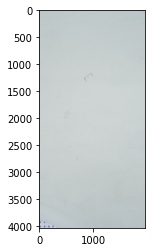

In [33]:

Im = images[0]
Im = Im.astype('float32')
Im /= 255.0
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(Im)

In [34]:
M = 64
N = 64
rows = 4032
cols = 1920
data = []
Num = 1

Im = Im[:rows,:cols]
tiles = [Im[x:x+M,y:y+N] for x in range(0,Im.shape[0],M) for y in range(0,Im.shape[1],N)]
for idx in range(Num):
  for tile in tiles:
    data.append(tile)
    data.append(np.fliplr(tile))
    data.append(np.flipud(tile))
    data.append(np.flipud(np.fliplr(tile)))

#from list to dataset
tiles2 = np.stack(data)
tiles2 = tiles2.reshape(len(data),64,64,3)
nptiles = np.transpose(tiles2, (0,3,1,2))
tensor_tiles = torch.tensor(nptiles)
dataset = TensorDataset(tensor_tiles)

In [35]:
batch_size = 20
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


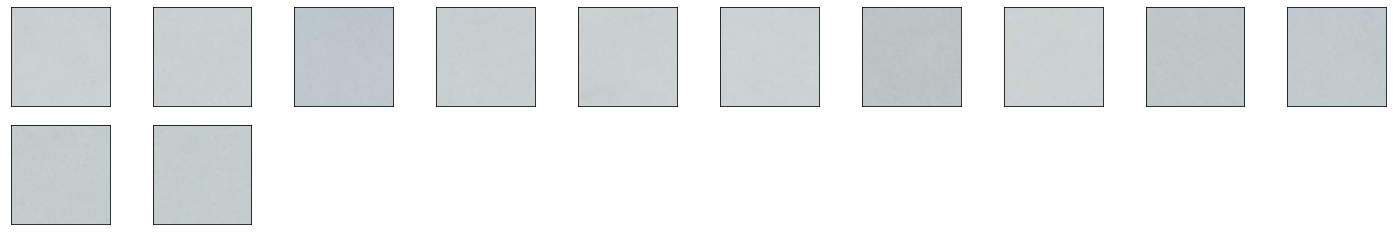

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images = dataiter.next()
images = np.squeeze(np.stack(images))
images.shape

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(12):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])



In [37]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [38]:
# specify loss function
criterion = nn.BCELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 10

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images = torch.squeeze(torch.stack(data))
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 10.662377
Epoch: 2 	Training Loss: 10.131433
Epoch: 3 	Training Loss: 10.131162
Epoch: 4 	Training Loss: 10.130839
Epoch: 5 	Training Loss: 10.130418
Epoch: 6 	Training Loss: 10.129916
Epoch: 7 	Training Loss: 10.129181
Epoch: 8 	Training Loss: 10.127965
Epoch: 9 	Training Loss: 10.126503
Epoch: 10 	Training Loss: 10.124921


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


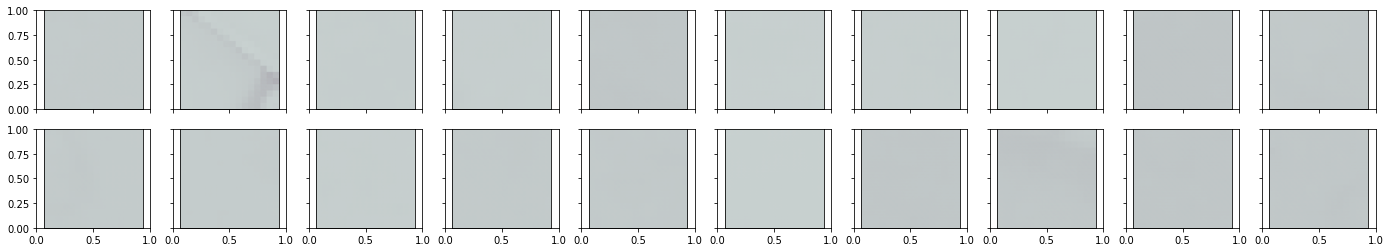

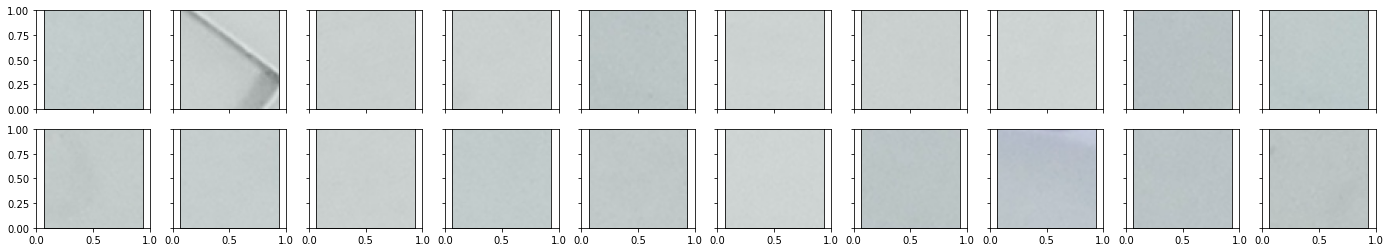

In [39]:
# obtain one batch of test images
dataiter = iter(test_loader)
images = dataiter.next()
images = torch.squeeze(torch.stack(images))
# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()




# output is resized into a batch of iages
output = output.view(batch_size, 3, N, M)
# use detach when it's an output that requires_grad
output = output.detach().numpy()


# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    # plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


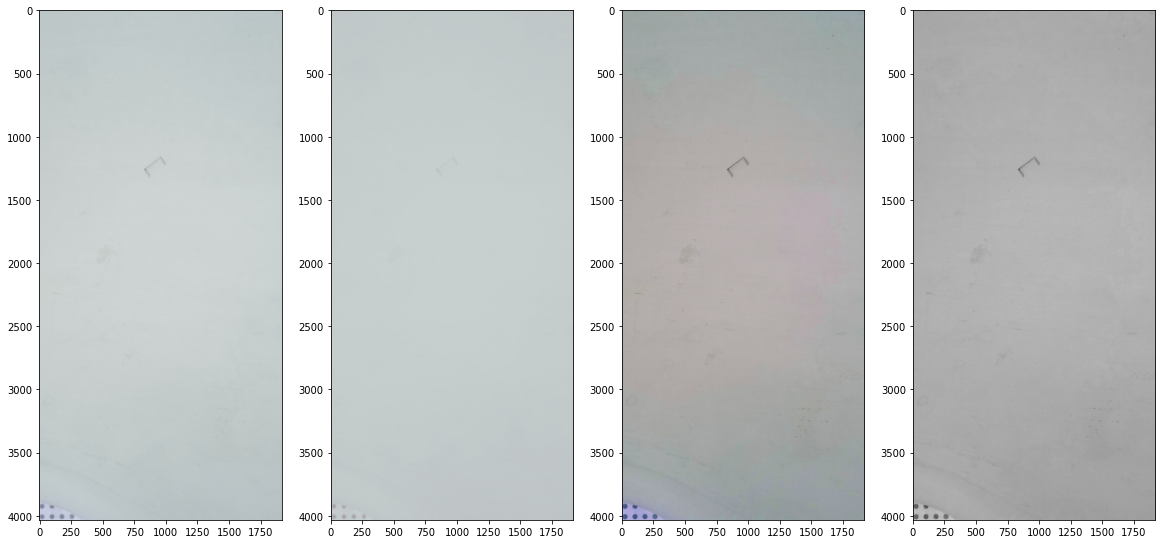

In [40]:

Im1 = cv2.imread('/content/gdrive/My Drive/project2/FinalTest/192.jpg')

N = 64
M = 64
rows = 4032
cols = 1920
Im = Im1[:rows,:cols].astype('float32')
Im /= 255.0

tiles = [Im[x:x+M,y:y+N] for x in range(0,Im.shape[0],M) for y in range(0,Im.shape[1],N)]
tiles2 = np.stack(tiles)
nptiles = np.transpose(tiles2, (0,3,1,2))
images = torch.tensor(nptiles)
# get sample outputs
output = model(images)
output = np.transpose(output.detach().numpy(),(0,2,3,1))
numrows = rows//N
numcols = cols//M
output = output.reshape(numrows, numcols, N, M,3).swapaxes(1, 2).reshape(N*numrows, M*numcols, 3)
plt.figure(figsize= (20,60))
plt.subplot(1,4,1)
plt.imshow(Im)
plt.subplot(1,4,2)    
plt.imshow(output)

diff = Im - output
norm_diff = cv2.normalize(diff, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
graydiff = cv2.cvtColor(norm_diff, cv2.COLOR_BGR2GRAY)


plt.subplot(1,4,3)
plt.imshow(norm_diff)
plt.subplot(1,4,4)
plt.imshow(graydiff, cmap="gray")

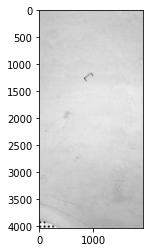

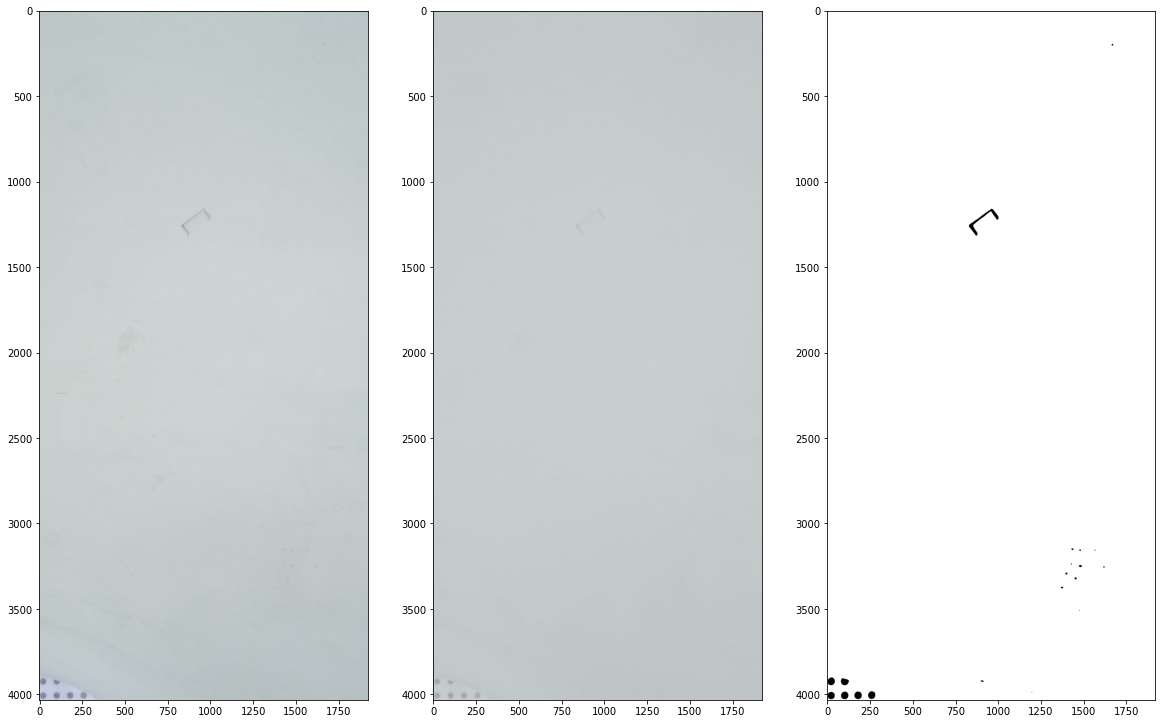

In [43]:
blur = skimage.filters.gaussian(graydiff, sigma=5)
plt.imshow(blur, cmap="gray")
mask = blur > 0.6

plt.figure(figsize= (20, 60))
plt.subplot(1,3,1)
plt.imshow(Im)
plt.subplot(1,3,2)    
plt.imshow(output)
plt.subplot(1,3,3)    

plt.imshow(mask, cmap = "gray")


